## Imports

In [1]:
import re
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from model_utility import SYMBOLS

## Configurations

In [2]:
plt.style.use('ggplot')

with open("configs.json", "r") as config_file:
    configs = json.load(config_file)

configs

{'DATASET_BASE_PATH': '../GitHub Repo Sample Data/'}

## Data Loading

In [3]:
filecontent_df = pd.read_csv(configs["DATASET_BASE_PATH"] + "filecontent_with_top_ext.csv", dtype = str, lineterminator="\n")
filecontent_df.head()

,sample_path,content,extension
0,Unity/Assets/eDriven/Demo/_shared/Materials/Ma...,fileFormatVersion: 2\nguid: 83fb76c2876417a4cb...,meta
1,Assets/RPGSystems/Scripts/Stats/RPGStatCollect...,fileFormatVersion: 2\nguid: 172ba00023166314c8...,meta
2,Assets/singleplayer/scripts/SingleGameUnit.cs....,fileFormatVersion: 2\nguid: 5343291fbebbcdb4fa...,meta
3,Assets/Textures/Pictures/cars/quad/Resources/q...,fileFormatVersion: 2\nguid: 9057805e7fcf641ccb...,meta
4,Assets/Art/Characters/99 Super Sanic/SuperSani...,fileFormatVersion: 2\nguid: fa975b7184d12a446b...,meta


In [4]:
filecontent_df.shape

(388009, 3)

In [5]:
filecontent_df.isnull().sum()

sample_path    0
content        0
extension      0
dtype: int64

In [6]:
filecontent_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388009 entries, 0 to 388008
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   sample_path  388009 non-null  object
 1   content      388009 non-null  object
 2   extension    388009 non-null  object
dtypes: object(3)
memory usage: 1.1 GB


## Feature engineering and EDA

### Content length in characters

In [7]:
filecontent_df['content_len'] = filecontent_df['content'].str.len()
filecontent_df.head()

,sample_path,content,extension,content_len
0,Unity/Assets/eDriven/Demo/_shared/Materials/Ma...,fileFormatVersion: 2\nguid: 83fb76c2876417a4cb...,meta,981
1,Assets/RPGSystems/Scripts/Stats/RPGStatCollect...,fileFormatVersion: 2\nguid: 172ba00023166314c8...,meta,262
2,Assets/singleplayer/scripts/SingleGameUnit.cs....,fileFormatVersion: 2\nguid: 5343291fbebbcdb4fa...,meta,263
3,Assets/Textures/Pictures/cars/quad/Resources/q...,fileFormatVersion: 2\nguid: 9057805e7fcf641ccb...,meta,910
4,Assets/Art/Characters/99 Super Sanic/SuperSani...,fileFormatVersion: 2\nguid: fa975b7184d12a446b...,meta,1121


In [8]:
MIN_CHAR_COUNT = filecontent_df['content_len'].min()
MAX_CHAR_COUNT = filecontent_df['content_len'].max()
filecontent_df['content_len'].describe()

count    388009.000000
mean       2390.042447
std        1482.940609
min         256.000000
25%         923.000000
50%        2220.000000
75%        4096.000000
max        4096.000000
Name: content_len, dtype: float64

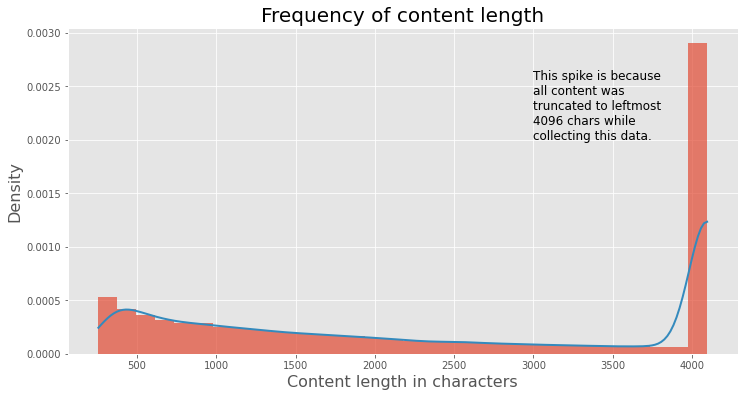

In [9]:
plt.figure(figsize = (12, 6))

plt.hist(filecontent_df['content_len'], bins = 32, density=True, alpha = 0.7, range = (MIN_CHAR_COUNT, MAX_CHAR_COUNT))

sns.kdeplot(filecontent_df['content_len'], clip = (MIN_CHAR_COUNT, MAX_CHAR_COUNT), linewidth = 2)

plt.text(
    3000, 0.002, 
    f"This spike is because \nall content was \ntruncated to leftmost \n{MAX_CHAR_COUNT} chars while \ncollecting this data.", 
    fontsize = 12)
plt.xlabel("Content length in characters", fontsize = 16)
plt.ylabel("Density", fontsize = 16)
plt.title("Frequency of content length", fontsize = 20)
plt.show()

In [10]:
avg_len_by_extn = filecontent_df.groupby("extension").agg({"content_len": np.mean}).sort_values("content_len")
avg_len_by_extn.round(1)

,content_len
extension,
llocs,517.2
pgm,582.1
geojson,790.8
meta,895.3
bb,973.6
...,...
ipynb,3793.2
vcproj,4017.4
vcxproj,4055.0


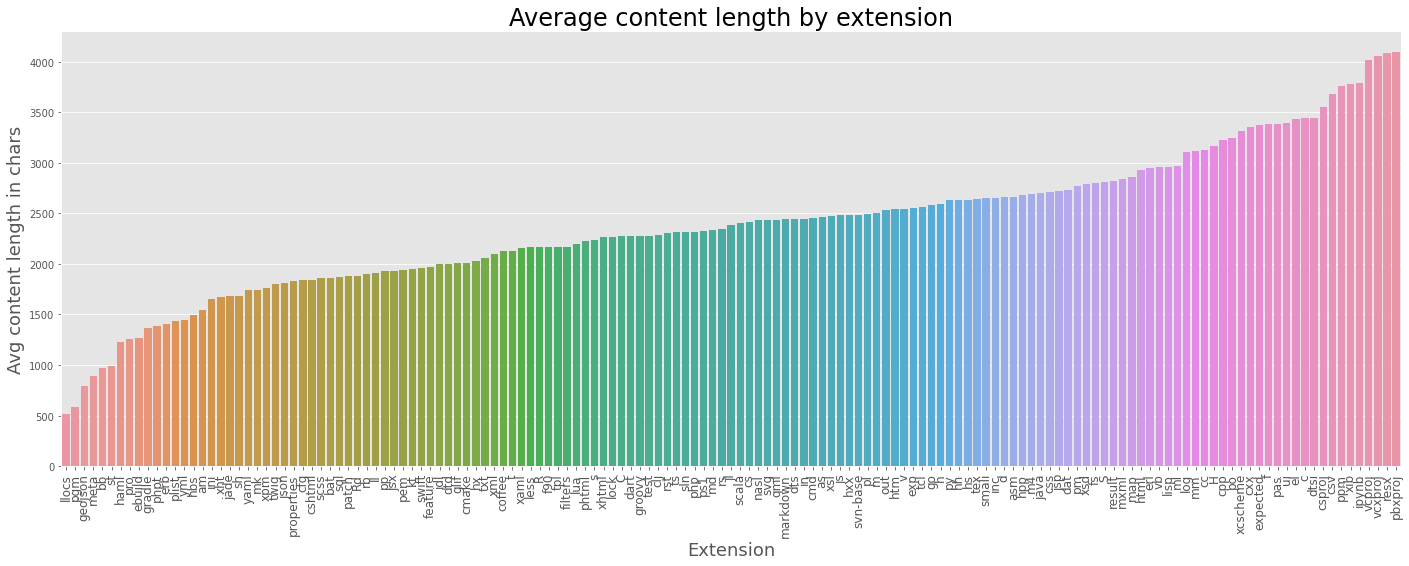

In [11]:
plt.figure(figsize = (24, 8))
sns.barplot(data = avg_len_by_extn, y = "content_len", x = avg_len_by_extn.index)
plt.xticks(range(len(avg_len_by_extn)), avg_len_by_extn.index, rotation = 90, fontsize = 12)
plt.xlabel("Extension", fontsize = 18)
plt.ylabel("Avg content length in chars", fontsize = 18)
plt.title("Average content length by extension", fontsize = 24)
plt.show()

### Symbol counts

In [12]:
%%time
symbol_count_cols = []

for symbol in SYMBOLS:
    symbol_col_name = f"Norm Count {symbol}"
    filecontent_df[symbol_col_name] = filecontent_df["content"].str.count(re.escape(symbol)) / filecontent_df["content_len"]
    symbol_count_cols.append(symbol_col_name)

filecontent_df.shape

Wall time: 27.5 s


(388009, 25)

In [13]:
filecontent_df.describe().round(2)

,content_len,Norm Count,Norm Count \n,Norm Count \t,Norm Count _,Norm Count +,Norm Count -,Norm Count *,Norm Count /,Norm Count %,...,Norm Count --,Norm Count **,Norm Count //,Norm Count %%,Norm Count ==,Norm Count +=,Norm Count -=,Norm Count *=,Norm Count /=,Norm Count %=
count,388009.00,388009.00,388009.00,388009.00,388009.00,388009.00,388009.00,388009.00,388009.00,388009.00,...,388009.00,388009.00,388009.00,388009.00,388009.00,388009.00,388009.00,388009.00,388009.00,388009.00
mean,2390.04,0.15,0.03,0.01,0.01,0.00,0.01,0.00,0.01,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
std,1482.94,0.09,0.02,0.02,0.01,0.01,0.03,0.02,0.02,0.01,...,0.01,0.01,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.00
min,256.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,923.00,0.09,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,2220.00,0.14,0.03,0.00,0.00,0.00,0.00,0.00,0.01,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,4096.00,0.20,0.04,0.00,0.01,0.00,0.01,0.00,0.02,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,4096.00,0.95,0.54,0.48,0.47,0.82,0.79,0.86,0.75,0.37,...,0.38,0.40,0.37,0.18,0.36,0.07,0.13,0.03,0.04,0.04
